In [ ]:
!pip install hazm
!pip install bs4
!pip install parsivar
!pip install emoji
!pip install transformers==4.37.2

  Using cached parsivar-0.2.3.1-py3-none-any.whl (18.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/persian-tweets-emotional-dataset.zip'

Archive:  /content/drive/MyDrive/persian-tweets-emotional-dataset.zip
  inflating: anger.csv               
  inflating: disgust.csv             
  inflating: fear.csv                
  inflating: joy.csv                 
  inflating: sad.csv                 
  inflating: surprise.csv            


In [ ]:
import re
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, TFAutoModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt

# 1.1 Dataset

                                               tweet emotion
0  در دلم چیزی ویران شده، چیزی که نمی‌دانم چیست و...    fear
1  هرگز نباید در پی حذف اضطراب باشیم. تشویش هموار...    fear
2  احساسات به افراد لطمه نمی زنند، دفاع ها لطمه م...    fear
3   اتفاقاً اونا از اضطراب و ترس قهرمانی #پرسپولی...    fear
4  ❤️در دلم چیزی ویران شده،\n چیزی که نمی‌دانم چی...    fear


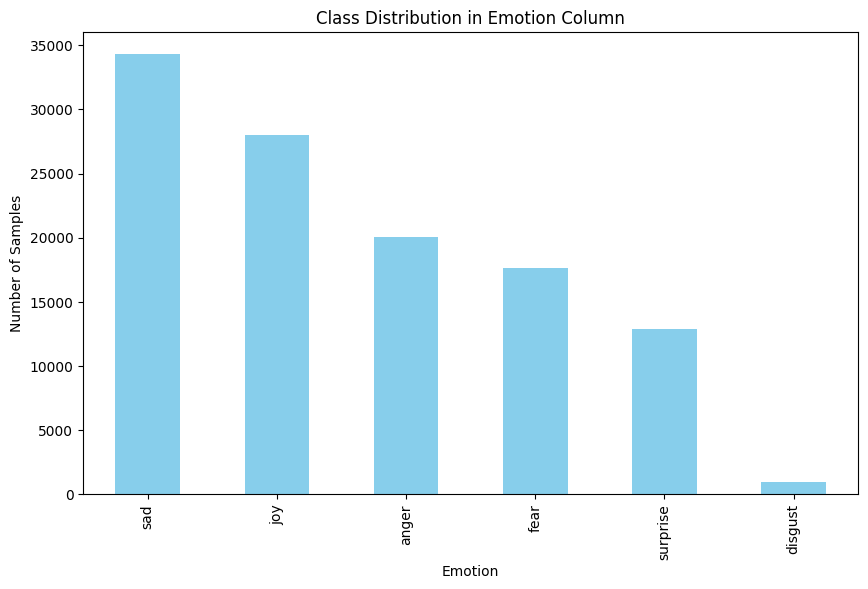

In [ ]:
# Load your dataset from multiple CSV files
csv_files = glob('./*.csv')  # Replace with the actual path to your CSV files
dfs = []
#read and append df
for file in csv_files:
    df = pd.read_csv(file, usecols=['tweet', 'emotion'])
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
print(df.head())
# Display bar chart of class distribution
emotion_counts = df['emotion'].value_counts()
emotion_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Class Distribution in Emotion Column')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.show()

# 1.2 Data Preprocessing

In [ ]:
import re
from bs4 import BeautifulSoup
from hazm import Normalizer, word_tokenize, Stemmer, stopwords_list
from parsivar import Normalizer as ParsivarNormalizer
from parsivar import SpellCheck
import emoji

def remove_html_and_urls(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    return text

def remove_repetitive_characters(text):
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    return text

def remove_stopwords(text):
    stopwords = stopwords_list()
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

def stemming(text):
    stemmer = Stemmer()
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def replace_emojis(text):
    return emoji.demojize(text, language="fa")

def preprocess_tweet(tweet):
    tweet = remove_html_and_urls(tweet)
    tweet = remove_repetitive_characters(tweet)
    tweet = remove_stopwords(tweet)
    tweet = replace_emojis(tweet)
    tweet = stemming(tweet)
    #tweet = correct_spelling(tweet)
    return tweet

df['processed_tweet'] = df['tweet'].apply(preprocess_tweet)

<ipython-input-7-853b9a9285d6>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
def preprocess_tweet(tweet):
    print(tweet)
    print('-------------------------')
    tweet = remove_html_and_urls(tweet)
    print(tweet)
    print('-------------------------')
    tweet = remove_repetitive_characters(tweet)
    print(tweet)
    print('-------------------------')
    tweet = remove_stopwords(tweet)
    print(tweet)
    print('-------------------------')
    tweet = replace_emojis(tweet)
    print(tweet)
    print('-------------------------')
    tweet = stemming(tweet)
    print(tweet)
    #print('-------------------------')
    #tweet = correct_spelling(tweet)
    return tweet

# Preprocess a sample tweet for demonstration
sample_tweet = df['tweet'].iloc[0]
preprocessed_sample_tweet = preprocess_tweet(sample_tweet)

 نمیدونم چی قبول شدی ولی اییییییوللللللل فاااایتیییینگ من بهت افتخار میکنم مونببه گوگولی🥳🥳
 #monstax
-------------------------
 نمیدونم چی قبول شدی ولی اییییییوللللللل فاااایتیییینگ من بهت افتخار میکنم مونببه گوگولی🥳🥳
 #monstax
-------------------------
 نمیدونم چی قبول شدی ولی ایول فایتینگ من بهت افتخار میکنم مونببه گوگولی🥳🥳
 #monstax
-------------------------
نمیدونم چی قبول شدی ایول فایتینگ بهت افتخار میکنم مونببه گوگولی🥳🥳 #monstax
-------------------------
نمیدونم چی قبول شدی ایول فایتینگ بهت افتخار میکنم مونببه گوگولی:جشن_و_سور::جشن_و_سور: #monstax
-------------------------
نمیدون چ قبول شد ایول فایتینگ به افتخار میکن مونببه گوگول : جشن_و_سور :: جشن_و_سور : #monstax


# 1.3 Feature Representation

In [ ]:
import gc
from transformers import AutoConfig
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

# Encode tweets
def encode_tweets(tweets):
    return tokenizer(tweets.tolist(), padding='max_length', truncation=True, max_length=32, return_tensors="tf")

X = encode_tweets(df['processed_tweet'])

bert_model = TFAutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
config.hidden_size = 120
model = TFAutoModel.from_config(config)
model.resize_token_embeddings(len(tokenizer))

# Get embeddings
def get_embeddings(input_ids, attention_mask, batch_size=8):
    num_samples = input_ids.shape[0]
    all_embeddings = []
    for i in range(0, num_samples, batch_size):
        batch_input_ids = input_ids[i:i + batch_size]
        batch_attention_mask = attention_mask[i:i + batch_size]
        outputs = bert_model(batch_input_ids, attention_mask=batch_attention_mask)
        last_hidden_state = outputs.last_hidden_state
        all_embeddings.append(last_hidden_state)
        gc.collect()
        return tf.concat(all_embeddings, axis=0)

# Get embeddings for the data
x_embeddings = get_embeddings(X['input_ids'], X['attention_mask'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/963M [00:00<?, ?B/s]

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# 1.4 Model Building

## Splitting the Data

In [ ]:
 truncation=True, max_length=32, return_tensors="tf")

# Split dataset for CNN-LSTM, CNN, and LSTM models
X_train, X_test, y_train, y_test = train_test_split(df['processed_tweet'], df['emotion'], test_size=0.3, random_state=42)
X_train_bert = encode_tweets(X_train)
X_test_bert = encode_tweets(X_test)

# One-hot encode the labels for multi-class classification
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

## CNN-LSTM

In [ ]:
# Hyperparameter search space
batch_sizes = [8, 64]
learning_rates = [0.001, 0.0001]
all_outputs = []
keys = ['Model', 'Batch', 'Learning Rate', 'Optimizer', 'Accuracy', 'Precision', 'Recall', 'F1 Measure']
outputs = {}

In [ ]:
 for batch in batch_sizes:
    for lr in learning_rates:
        # CNN-LSTM model
        input_ids = Input(shape=(32,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(32,), dtype=tf.int32, name='attention_mask')

        bert_model.trainable = False
        embeddings = bert_model({'input_ids':input_ids, 'attention_mask':attention_mask})[0]
        conv1d = Conv1D(32, kernel_size=5, activation='relu')(embeddings)
        max_pooling = MaxPooling1D(pool_size=2)(conv1d)
        lstm = LSTM(32)(max_pooling)
        dropout = Dropout(0.1)(lstm)
        output = Dense(len(df['emotion'].unique()), activation='softmax')(dropout)

        cnn_lstm_model = Model(inputs=[input_ids, attention_mask], outputs=output)
        optimizer = Adam(learning_rate=lr)
        cnn_lstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        cnn_lstm_model.fit(
            {'input_ids': X_train_bert['input_ids'], 'attention_mask': X_train_bert['attention_mask']},
            y_train_encoded,
            epochs=10,
            batch_size=batch,
            validation_split=0.2,
            verbose=1
        )
        cnn_lstm_y_pred = cnn_lstm_model.predict(
            {'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']}
        )
        cnn_lstm_y_pred_classes = tf.argmax(cnn_lstm_y_pred, axis=1).numpy()


        cnn_lstm_accuracy = accuracy_score(y_test, cnn_lstm_y_pred_classes)
        cnn_lstm_precision = precision_score(y_test, cnn_lstm_y_pred_classes, average='weighted')
        cnn_lstm_recall = recall_score(y_test, cnn_lstm_y_pred_classes, average='weighted')
        cnn_lstm_f1 = f1_score(y_test, cnn_lstm_y_pred_classes, average='weighted')

        outputs.update({'Model': 'CNN-LSTM',
                        'Batch': batch,
                        'Learning Rate': lr,
                        'Optimizer': 'Adam',
                        'Accuracy': cnn_lstm_accuracy,
                        'Precision': cnn_lstm_precision,
                        'Recall': cnn_lstm_recall,
                        'F1 Score': cnn_lstm_f1})

        print(outputs)

        all_outputs.append(outputs)

Epoch 1/10
7968/7968 [==============================] - 213s 26ms/step - loss: 0.9361 - accuracy: 0.6559 - val_loss: 0.6291 - val_accuracy: 0.7833
Epoch 2/10
7968/7968 [==============================] - 206s 26ms/step - loss: 0.5841 - accuracy: 0.7994 - val_loss: 0.5309 - val_accuracy: 0.8145
Epoch 3/10
7968/7968 [==============================] - 206s 26ms/step - loss: 0.5195 - accuracy: 0.8197 - val_loss: 0.4979 - val_accuracy: 0.8242
Epoch 4/10
7968/7968 [==============================] - 206s 26ms/step - loss: 0.4901 - accuracy: 0.8291 - val_loss: 0.4845 - val_accuracy: 0.8326
Epoch 5/10
7968/7968 [==============================] - 205s 26ms/step - loss: 0.4714 - accuracy: 0.8361 - val_loss: 0.4717 - val_accuracy: 0.8352
Epoch 6/10
7968/7968 [==============================] - 201s 25ms/step - loss: 0.4552 - accuracy: 0.8421 - val_loss: 0.4674 - val_accuracy: 0.8382
Epoch 7/10
7968/7968 [==============================] - 205s 26ms/step - loss: 0.4437 - accuracy: 0.8445 - val_loss: 0

In [ ]:


for batch in batch_sizes:
    for lr in learning_rates:
        # CNN-LSTM model
        input_ids = Input(shape=(32,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(32,), dtype=tf.int32, name='attention_mask')
        bert_model.trainable = False
        embeddings = bert_model({'input_ids':input_ids, 'attention_mask':attention_mask})[0]
        conv1d = Conv1D(32, kernel_size=5, activation='relu')(embeddings)
        max_pooling = MaxPooling1D(pool_size=2)(conv1d)
        lstm = LSTM(32)(max_pooling)
        dropout = Dropout(0.1)(lstm)
        output = Dense(len(df['emotion'].unique()), activation='softmax')(dropout)

        cnn_lstm_model = Model(inputs=[input_ids, attention_mask], outputs=output)
        optimizer = SGD(learning_rate=lr)
        cnn_lstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        cnn_lstm_model.fit(
            {'input_ids': X_train_bert['input_ids'], 'attention_mask': X_train_bert['attention_mask']},
            y_train_encoded,
            epochs=10,
            batch_size=batch,
            validation_split=0.2,
            verbose=1
        )
        cnn_lstm_y_pred = cnn_lstm_model.predict(
            {'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']}
        )
        cnn_lstm_y_pred_classes = tf.argmax(cnn_lstm_y_pred, axis=1).numpy()

        y_test_classes = pd.factorize(y_test)[0]

        cnn_lstm_accuracy = accuracy_score(y_test_classes, cnn_lstm_y_pred_classes)
        cnn_lstm_precision = precision_score(y_test_classes, cnn_lstm_y_pred_classes, average='weighted')
        cnn_lstm_recall = recall_score(y_test_classes, cnn_lstm_y_pred_classes, average='weighted')
        cnn_lstm_f1 = f1_score(y_test_classes, cnn_lstm_y_pred_classes, average='weighted')

        outputs.update({'Model': 'CNN-LSTM',
                        'Batch': batch,
                        'Learning Rate': lr,
                        'Optimizer': 'SGD',
                        'Accuracy': cnn_lstm_accuracy,
                        'Precision': cnn_lstm_precision,
                        'Recall': cnn_lstm_recall,
                        'F1 Score': cnn_lstm_f1})
        print(outputs)

        all_outputs.append(outputs)

Epoch 1/10
7968/7968 [==============================] - 219s 26ms/step - loss: 1.3837 - accuracy: 0.4404 - val_loss: 1.1808 - val_accuracy: 0.5601
Epoch 2/10
7968/7968 [==============================] - 207s 26ms/step - loss: 1.1515 - accuracy: 0.5652 - val_loss: 1.0497 - val_accuracy: 0.6153
Epoch 3/10
7968/7968 [==============================] - 203s 25ms/step - loss: 1.0276 - accuracy: 0.6237 - val_loss: 0.9223 - val_accuracy: 0.6711
Epoch 4/10
7968/7968 [==============================] - 206s 26ms/step - loss: 0.9205 - accuracy: 0.6723 - val_loss: 0.8345 - val_accuracy: 0.7074
Epoch 5/10
7968/7968 [==============================] - 201s 25ms/step - loss: 0.8371 - accuracy: 0.7064 - val_loss: 0.7619 - val_accuracy: 0.7362
Epoch 6/10
7968/7968 [==============================] - 206s 26ms/step - loss: 0.7662 - accuracy: 0.7334 - val_loss: 0.7088 - val_accuracy: 0.7543
Epoch 7/10
7968/7968 [==============================] - 207s 26ms/step - loss: 0.7071 - accuracy: 0.7558 - val_loss: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Model': 'CNN-LSTM', 'Batch': 8, 'Learning Rate': 0.0001, 'Optimizer': 'SGD', 'Accuracy': 0.4460452721895224, 'Precision': 0.4311977852310884, 'Recall': 0.4460452721895224, 'F1 Score': 0.43749728764094925}
Epoch 1/10
996/996 [==============================] - 182s 174ms/step - loss: 1.6355 - accuracy: 0.2894 - val_loss: 1.5633 - val_accuracy: 0.3110
Epoch 2/10
996/996 [==============================] - 161s 161ms/step - loss: 1.5382 - accuracy: 0.3339 - val_loss: 1.4854 - val_accuracy: 0.3744
Epoch 3/10
996/996 [==============================] - 171s 172ms/step - loss: 1.4468 - accuracy: 0.4090 - val_loss: 1.3650 - val_accuracy: 0.4646
Epoch 4/10
996/996 [==============================] - 161s 161ms/step - loss: 1.3367 - accuracy: 0.4821 - val_loss: 1.2609 - val_accuracy: 0.5240
Epoch 5/10
996/996 [==============================] - 171s 172ms/step - loss: 1.2602 - accuracy: 0.5230 - val_loss: 1.1966 - val_accuracy: 0.5565
Epoch 6/10
996/996 [==============================] - 171s 172m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Model': 'CNN-LSTM', 'Batch': 64, 'Learning Rate': 0.001, 'Optimizer': 'SGD', 'Accuracy': 0.4470409089578026, 'Precision': 0.45490266562245263, 'Recall': 0.4470409089578026, 'F1 Score': 0.44927737613324337}
Epoch 1/10
996/996 [==============================] - 185s 174ms/step - loss: 1.7252 - accuracy: 0.2396 - val_loss: 1.6620 - val_accuracy: 0.2506
Epoch 2/10
996/996 [==============================] - 161s 161ms/step - loss: 1.6575 - accuracy: 0.2661 - val_loss: 1.6336 - val_accuracy: 0.2690
Epoch 3/10
996/996 [==============================] - 160s 161ms/step - loss: 1.6366 - accuracy: 0.2771 - val_loss: 1.6164 - val_accuracy: 0.2776
Epoch 4/10
996/996 [==============================] - 171s 172ms/step - loss: 1.6215 - accuracy: 0.2834 - val_loss: 1.6029 - val_accuracy: 0.2884
Epoch 5/10
996/996 [==============================] - 161s 161ms/step - loss: 1.6104 - accuracy: 0.2910 - val_loss: 1.5917 - val_accuracy: 0.3015
Epoch 6/10
996/996 [==============================] - 161s 161

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN

In [ ]:
# CNN model
input_ids = Input(shape=(32,), dtype=tf.int32)
attention_mask = Input(shape=(32,), dtype=tf.int32)
bert_model.trainable = False
embeddings = bert_model({'input_ids':input_ids, 'attention_mask':attention_mask})[0]
conv1d = Conv1D(32, kernel_size=5, activation='relu')(embeddings)
global_max_pooling = GlobalMaxPooling1D()(conv1d)
dropout = Dropout(0.1)(global_max_pooling)
output = Dense(len(df['emotion'].unique()), activation='softmax')(dropout)

cnn_model = Model(inputs=[input_ids, attention_mask], outputs=output)
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask']],
    y_train_encoded,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

cnn_y_pred = cnn_model.predict(
    [X_test_bert['input_ids'], X_test_bert['attention_mask']]
)
cnn_y_pred_classes = tf.argmax(cnn_y_pred, axis=1).numpy()
y_test_classes = pd.factorize(y_test)[0]
cnn_accuracy = accuracy_score(y_test_classes, cnn_y_pred_classes)
cnn_precision = precision_score(y_test_classes, cnn_y_pred_classes, average='weighted')
cnn_recall = recall_score(y_test_classes, cnn_y_pred_classes, average='weighted')
cnn_f1 = f1_score(y_test_classes, cnn_y_pred_classes, average='weighted')
outputs.update({'Model': 'CNN',
                'Batch': 64,
                'Learning Rate': 0.001,
                'Optimizer': 'Adam',
                'Accuracy': cnn_accuracy,
                'Precision': cnn_precision,
                'Recall': cnn_recall,
                'F1 Score': cnn_f1})
all_outputs.append(outputs)
print(outputs)

Epoch 1/10
996/996 [==============================] - 174s 166ms/step - loss: 0.8460 - accuracy: 0.6985 - val_loss: 0.5587 - val_accuracy: 0.8108
Epoch 2/10
996/996 [==============================] - 162s 163ms/step - loss: 0.5864 - accuracy: 0.7997 - val_loss: 0.4995 - val_accuracy: 0.8377
Epoch 3/10
996/996 [==============================] - 172s 173ms/step - loss: 0.5367 - accuracy: 0.8176 - val_loss: 0.4915 - val_accuracy: 0.8373
Epoch 4/10
996/996 [==============================] - 163s 164ms/step - loss: 0.5054 - accuracy: 0.8282 - val_loss: 0.4748 - val_accuracy: 0.8424
Epoch 5/10
996/996 [==============================] - 162s 163ms/step - loss: 0.4840 - accuracy: 0.8346 - val_loss: 0.4716 - val_accuracy: 0.8439
Epoch 6/10
996/996 [==============================] - 172s 173ms/step - loss: 0.4686 - accuracy: 0.8404 - val_loss: 0.4685 - val_accuracy: 0.8457
Epoch 7/10
996/996 [==============================] - 172s 173ms/step - loss: 0.4543 - accuracy: 0.8445 - val_loss: 0.4823 -

## LSTM

In [ ]:
# LSTM model
input_ids = Input(shape=(32,), dtype=tf.int32)
attention_mask = Input(shape=(32,), dtype=tf.int32)

bert_model.trainable = False
embeddings = bert_model({'input_ids':input_ids, 'attention_mask':attention_mask})[0]
lstm = LSTM(32)(embeddings)
dropout = Dropout(0.1)(lstm)
output = Dense(len(df['emotion'].unique()), activation='softmax')(dropout)

lstm_model = Model(inputs=[input_ids, attention_mask], outputs=output)
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask']],
    y_train_encoded,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

lstm_y_pred = lstm_model.predict(
    [X_test_bert['input_ids'], X_test_bert['attention_mask']]
)
lstm_y_pred_classes = tf.argmax(lstm_y_pred, axis=1).numpy()
y_test_classes = pd.factorize(y_test)[0]

lstm_accuracy = accuracy_score(y_test_classes, lstm_y_pred_classes)
lstm_precision = precision_score(y_test_classes, lstm_y_pred_classes, average='weighted')
lstm_recall = recall_score(y_test_classes, lstm_y_pred_classes, average='weighted')
lstm_f1 = f1_score(y_test_classes, lstm_y_pred_classes, average='weighted')

outputs.update({'Model': 'LSTM',
                'Batch': 64,
                'Learning Rate': 0.001,
                'Optimizer': 'Adam',
                'Accuracy': lstm_accuracy,
                'Precision': lstm_precision,
                'Recall': lstm_recall,
                'F1 Score': lstm_f1})
print(outputs)

Epoch 1/10
996/996 [==============================] - 187s 178ms/step - loss: 0.8760 - accuracy: 0.6831 - val_loss: 0.5667 - val_accuracy: 0.8077
Epoch 2/10
996/996 [==============================] - 165s 165ms/step - loss: 0.5298 - accuracy: 0.8220 - val_loss: 0.4772 - val_accuracy: 0.8384
Epoch 3/10
996/996 [==============================] - 164s 165ms/step - loss: 0.4663 - accuracy: 0.8402 - val_loss: 0.4453 - val_accuracy: 0.8462
Epoch 4/10
996/996 [==============================] - 164s 164ms/step - loss: 0.4328 - accuracy: 0.8517 - val_loss: 0.4232 - val_accuracy: 0.8528
Epoch 5/10
996/996 [==============================] - 164s 164ms/step - loss: 0.4107 - accuracy: 0.8573 - val_loss: 0.4194 - val_accuracy: 0.8544
Epoch 6/10
996/996 [==============================] - 174s 175ms/step - loss: 0.3998 - accuracy: 0.8605 - val_loss: 0.4123 - val_accuracy: 0.8562
Epoch 7/10
996/996 [==============================] - 174s 175ms/step - loss: 0.3879 - accuracy: 0.8658 - val_loss: 0.4126 -

# 1.6 Extra Points

### Max Features = 120

In [ ]:
# Sample a portion of the dataset for traditional ML models
sample_df = df.sample(frac=0.1, random_state=42)  # Use 10% of the data for this section
sample_df['processed_tweet'] = sample_df['tweet'].apply(preprocess_tweet)
X_sample = sample_df['processed_tweet']
y_sample = sample_df['emotion']

# Split the sampled dataset
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

# Convert to BOW representation
vectorizer = CountVectorizer(max_features=120)
X_train_bow_sample = vectorizer.fit_transform(X_train_sample)#تبدیل داده‌های آموزشی به ماتریس برداری:


X_test_bow_sample = vectorizer.transform(X_test_sample)

# Traditional Machine Learning Models
models = {
    'GaussianNB': GaussianNB(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=200),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier()
}

results_ml = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for model_name, model in models.items():
    model.fit(X_train_bow_sample.toarray(), y_train_sample)
    y_pred_sample = model.predict(X_test_bow_sample.toarray())

    accuracy = accuracy_score(y_test_sample, y_pred_sample)
    precision = precision_score(y_test_sample, y_pred_sample, average='weighted')
    recall = recall_score(y_test_sample, y_pred_sample, average='weighted')
    f1 = f1_score(y_test_sample, y_pred_sample, average='weighted')

    results_ml['Model'].append(model_name)
    results_ml['Accuracy'].append(accuracy)
    results_ml['Precision'].append(precision)
    results_ml['Recall'].append(recall)
    results_ml['F1 Score'].append(f1)


<ipython-input-5-853b9a9285d6>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
results_ml

{'Model': ['GaussianNB',
  'GradientBoosting',
  'LogisticRegression',
  'DecisionTree',
  'RandomForest'],
 'Accuracy': [0.3973645680819912,
  0.5909224011713031,
  0.5809663250366032,
  0.5197657393850659,
  0.5657393850658858],
 'Precision': [0.6260240492003633,
  0.6936045078024414,
  0.6351424129378278,
  0.5184150555644802,
  0.5693142078441351],
 'Recall': [0.3973645680819912,
  0.5909224011713031,
  0.5809663250366032,
  0.5197657393850659,
  0.5657393850658858],
 'F1 Score': [0.438971110772201,
  0.5745678624951516,
  0.5737110681102835,
  0.5181859100682368,
  0.562384662188194]}

### Max Features = 1000

In [ ]:
# Convert to BOW representation
vectorizer = CountVectorizer(max_features=1000)
X_train_bow_sample = vectorizer.fit_transform(X_train_sample)
X_test_bow_sample = vectorizer.transform(X_test_sample)

# Traditional Machine Learning Models
models = {
    'GaussianNB': GaussianNB(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=200),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier()
}

results_ml = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for model_name, model in models.items():
    model.fit(X_train_bow_sample.toarray(), y_train_sample)
    y_pred_sample = model.predict(X_test_bow_sample.toarray())

    accuracy = accuracy_score(y_test_sample, y_pred_sample)
    precision = precision_score(y_test_sample, y_pred_sample, average='weighted')
    recall = recall_score(y_test_sample, y_pred_sample, average='weighted')
    f1 = f1_score(y_test_sample, y_pred_sample, average='weighted')

    results_ml['Model'].append(model_name)
    results_ml['Accuracy'].append(accuracy)
    results_ml['Precision'].append(precision)
    results_ml['Recall'].append(recall)
    results_ml['F1 Score'].append(f1)

results_ml

{'Model': ['GaussianNB',
  'GradientBoosting',
  'LogisticRegression',
  'DecisionTree',
  'RandomForest'],
 'Accuracy': [0.5625183016105417,
  0.8500732064421669,
  0.8383601756954612,
  0.8234260614934115,
  0.8541727672035139],
 'Precision': [0.6692983671722953,
  0.8670579695279849,
  0.8393177721591909,
  0.8237853011878261,
  0.8567828844839724],
 'Recall': [0.5625183016105417,
  0.8500732064421669,
  0.8383601756954612,
  0.8234260614934115,
  0.8541727672035139],
 'F1 Score': [0.5684016041985177,
  0.8517687556283515,
  0.8382915895909199,
  0.8233486610127702,
  0.8542327833584417]}